<a href="https://colab.research.google.com/github/IshanGProjects/BallinFPGA/blob/main/Deep_Neural_Network_Rainfall_Prediction_in_Australia_Using_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Neural Network Concepts


## Key Concepts of Deep Neural Networks

Deep Neural Networks (DNNs) are a subset of artificial neural networks that are characterized by their depth, which refers to the number of layers of neurons in the network. These networks can learn complex patterns in data by passing input through these layers where each layer extracts and refines features from the input.

#### Architectures Relevant to Time-Series Data

1. **Long Short-Term Memory (LSTM)**:
   - **Structure**: LSTMs are a type of Recurrent Neural Network (RNN) designed to overcome the vanishing gradient problem in standard RNNs. They have a chain-like structure with repeating modules of neural network layers. Each module includes a cell state and three types of gates: input, forget, and output gates.
   - **Functionality**: The cell state acts as a conveyor belt, running down the entire chain, allowing information to flow unaltered. The gates regulate the flow of information into and out of the cell and can add or remove information to the cell state.
   - **Usefulness**: Ideal for time-series data as they can maintain long-term dependencies and remember patterns over long intervals.

2. **Gated Recurrent Unit (GRU)**:
   - **Structure**: GRUs are similar to LSTMs but are simpler with fewer parameters. They combine the forget and input gates into a single "update gate" and have a reset gate.
   - **Functionality**: The update gate helps the model to decide how much of the past information (from previous time steps) needs to be passed along to the future. The reset gate determines how much of the past information to forget.
   - **Usefulness**: GRUs are more efficient than LSTMs in terms of computational resources and are effective in capturing dependencies in time-series data.

### Advantages of Deep Neural Networks in Processing Complex Patterns

1. **Feature Extraction**: DNNs automatically detect and extract features from raw data, eliminating the need for manual feature engineering. This is particularly useful in complex datasets where determining relevant features is difficult.

2. **Hierarchical Feature Learning**: They learn hierarchical representations, meaning lower layers capture basic features and higher layers combine these to form more abstract representations. This is essential in understanding complex patterns.

3. **Handling Non-linearity**: Deep networks, with their non-linear activation functions, can model complex non-linear relationships in the data.

4. **Large Data Handling**: DNNs excel in scenarios where vast amounts of data are available. They can uncover intricate structures in large datasets that simpler models might miss.

5. **Flexibility and Adaptability**: They can be adapted to a wide range of tasks, from image and speech recognition to time-series analysis.

6. **Temporal Dynamics Understanding**: In time-series data, architectures like LSTM and GRU can understand temporal dynamics and dependencies, making them well-suited for forecasting and sequence prediction tasks.

7. **Robustness to Noise**: Deep neural networks can be more robust to noise in the data compared to shallow networks, making them suitable for real-world applications where data quality might be an issue.

These advantages make deep neural networks a powerful tool in various fields where understanding complex patterns in data is crucial.

## Load Data

In [ ]:
from google.colab import files
uploaded = files.upload()

In [ ]:
!pip install optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 409.6/409.6 kB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 230.6/230.6 kB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 5.7 MB/s eta 0:00:00


In [ ]:
#Import
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import optuna
from torch.utils.data import DataLoader, TensorDataset
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from imblearn.over_sampling import SMOTE

In [ ]:
if torch.cuda.is_available():
    print("GPU is available")
    device = torch.device("cuda")
else:
    print("GPU is not available, using CPU")
    device = torch.device("cpu")

GPU is available


In [ ]:
weatherDF = pd.read_csv('weatherAUS.csv')

# Processing Time Data And Performing Circular Encoding

## Converting To Date Time

In [ ]:
#Function to handle the "Date" column
def remove_date(data):
    if 'Date' in data.columns:
        # Convert to datetime format
        data['Date'] = pd.to_datetime(data['Date'])

        # Extract components from the 'Date' column
        data['Year'] = data['Date'].dt.year
        data['Month'] = data['Date'].dt.month
        data['DayOfWeek'] = data['Date'].dt.dayofweek

        # Drop the 'Date' column
        data.drop('Date', axis=1, inplace=True)

    return data

In [ ]:
weatherDF = remove_date(weatherDF)

## Perfrom Circular Encoding

In [ ]:
def circularEncode(data, col, max_val):
    data[col + '_sin'] = np.sin(2 * np.pi * data[col] / max_val)
    data[col + '_cos'] = np.cos(2 * np.pi * data[col] / max_val)
    return data

In [ ]:
weatherDF = circularEncode(weatherDF, "DayOfWeek", 7)
weatherDF = circularEncode(weatherDF, "Month", 12)

In [ ]:
weatherDF.head()

,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,...,Temp3pm,RainToday,RainTomorrow,Year,Month,DayOfWeek,DayOfWeek_sin,DayOfWeek_cos,Month_sin,Month_cos
0,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,WNW,...,21.8,No,No,2008,12,0,0.000000,1.000000,-2.449294e-16,1.0
1,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,WSW,...,24.3,No,No,2008,12,1,0.781831,0.623490,-2.449294e-16,1.0
2,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,WSW,...,23.2,No,No,2008,12,2,0.974928,-0.222521,-2.449294e-16,1.0
3,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,E,...,26.5,No,No,2008,12,3,0.433884,-0.900969,-2.449294e-16,1.0
4,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,NW,...,29.7,No,No,2008,12,4,-0.433884,-0.900969,-2.449294e-16,1.0


# Perform Simple Imputation

Based off the analysis from the original Neural Network I have assesed the best way to impute the data using simple imputation methods, of either mean or median. Based of the Corresponding Distribution I apply that type of imputation method.

In [ ]:
imputer1 = SimpleImputer(missing_values=np.nan, strategy='mean')
imputer2 =SimpleImputer(missing_values = np.nan, strategy = 'median')
weatherDF[['Evaporation']] = imputer2.fit_transform(weatherDF[['Evaporation']])
weatherDF[['Sunshine']] = imputer1.fit_transform(weatherDF[['Sunshine']])
weatherDF[['Cloud3pm']] = imputer2.fit_transform(weatherDF[['Cloud3pm']])
weatherDF[['Cloud9am']] = imputer1.fit_transform(weatherDF[['Cloud9am']])
#mean and median are same for Pressure9am and Pressure3pm
weatherDF[['Pressure9am']] = imputer1.fit_transform(weatherDF[['Pressure9am']])
weatherDF[['Pressure3pm']] = imputer1.fit_transform(weatherDF[['Pressure3pm']])

Lets see how many missing values we have and what columns they correspond to decide what to do next.

In [ ]:
# Check for missing values in each column
missing_values_count = weatherDF.isnull().sum()

# Display columns with missing values and their count
print(missing_values_count[missing_values_count > 0])

MinTemp           1485
MaxTemp           1261
Rainfall          3261
WindGustDir      10326
WindGustSpeed    10263
WindDir9am       10566
WindDir3pm        4228
WindSpeed9am      1767
WindSpeed3pm      3062
Humidity9am       2654
Humidity3pm       4507
Temp9am           1767
Temp3pm           3609
RainToday         3261
RainTomorrow      3267
dtype: int64


Drop The missing values.

In [ ]:
weatherDF = weatherDF.dropna()

# Encoding Categorical Data
Most machine learning algorithms work with numerical input. They cannot process raw text or categorical data directly. Encoding transforms categorical data into a format that these algorithms can work with.

In [ ]:
def labelEncode(data, columns):
    le = LabelEncoder()
    for col in columns:
        # Check if the column is of categorical type
        if data[col].dtype == 'object' or data[col].dtype.name == 'category':
            # Apply Label Encoding
            data[col] = le.fit_transform(data[col])
    return data

In [ ]:
categoricalColumns = weatherDF.select_dtypes(include=['object']).columns

In [ ]:
 weatherDF = labelEncode(weatherDF, categoricalColumns)

In [ ]:
weatherDF.head()

,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,...,Temp3pm,RainToday,RainTomorrow,Year,Month,DayOfWeek,DayOfWeek_sin,DayOfWeek_cos,Month_sin,Month_cos
0,1,13.4,22.9,0.6,4.8,7.611178,13,44.0,13,14,...,21.8,0,0,2008,12,0,0.000000,1.000000,-2.449294e-16,1.0
1,1,7.4,25.1,0.0,4.8,7.611178,14,44.0,6,15,...,24.3,0,0,2008,12,1,0.781831,0.623490,-2.449294e-16,1.0
2,1,12.9,25.7,0.0,4.8,7.611178,15,46.0,13,15,...,23.2,0,0,2008,12,2,0.974928,-0.222521,-2.449294e-16,1.0
3,1,9.2,28.0,0.0,4.8,7.611178,4,24.0,9,0,...,26.5,0,0,2008,12,3,0.433884,-0.900969,-2.449294e-16,1.0
4,1,17.5,32.3,1.0,4.8,7.611178,13,41.0,1,7,...,29.7,0,0,2008,12,4,-0.433884,-0.900969,-2.449294e-16,1.0


# Balancing Data

Balancing data for response variables like "RainTomorrow" is important in machine learning, particularly in classification problems.

Avoiding Model Bias: In an imbalanced dataset, where one class significantly outnumbers the other, machine learning models tend to be biased towards the majority class. This means the model might perform well in predicting the majority class but poorly for the minority class, which is often the class of greater interest (like predicting rain).

We will also be evaluating "RainToday" because it logically has a big impact on "RainTomorrow"

In [ ]:
weatherDF["RainTomorrow"].value_counts()

0    94906
1    26884
Name: RainTomorrow, dtype: int64

In [ ]:
weatherDF["RainToday"].value_counts()

0    94537
1    27253
Name: RainToday, dtype: int64

In [ ]:
# Function to apply SMOTE for balancing
def apply_smote(X, y):
    smote = SMOTE()
    X_res, y_res = smote.fit_resample(X, y)
    return X_res, y_res

In [ ]:
# Assuming 'df' is your DataFrame and 'RainTomorrow' is the target variable
X = weatherDF.drop('RainTomorrow', axis=1)  # Independent variables
y = weatherDF['RainTomorrow']  # Dependent variable (target)

# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Apply SMOTE only on training data
X_train_res, y_train_res = apply_smote(X_train, y_train)

# Combining the resampled data back into a DataFrame
balanced_df = pd.concat([pd.DataFrame(X_train_res), pd.DataFrame(y_train_res)], axis=1)

# Check the new value counts
print(balanced_df['RainTomorrow'].value_counts())

0    66382
1    66382
Name: RainTomorrow, dtype: int64


## Split And Perform Feature Selection

In [ ]:
# Feature selection using SelectKBest
fs = SelectKBest(score_func=f_classif, k=15)
X_train_selected = fs.fit_transform(X_train_res, y_train_res)

# Checking the shape of the selected features
print(X_train_selected.shape)

(132764, 15)


In [ ]:
# Get columns to keep based on the training set
cols = fs.get_support(indices=True)

In [ ]:
# Apply the same column selection to both training and test sets
X_train_new = X_train_res.iloc[:, cols]
X_test_new = X_test.iloc[:, cols]

# Model Development with PyTorch

## Tensor and Data Loader Setup

In [ ]:
# Convert your balanced and feature-selected datasets to PyTorch tensors
X_train_tensor = torch.tensor(X_train_new.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_res.values, dtype=torch.float32).view(-1, 1)
X_test_tensor = torch.tensor(X_test_new.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)

# Create DataLoader instances
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=100, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=100, shuffle=False)

## Model

In [ ]:
class LSTM_Rain_Predictor(nn.Module):
    def __init__(self, n_features, hidden_units=100, dropout_rate=0.3):
        super(LSTM_Rain_Predictor, self).__init__()

        # First LSTM Layer
        self.lstm1 = nn.LSTM(input_size=n_features, hidden_size=hidden_units, batch_first=True)

        # Second LSTM Layer
        self.lstm2 = nn.LSTM(input_size=hidden_units, hidden_size=hidden_units, batch_first=True)

        # Dropout Layer
        self.dropout = nn.Dropout(dropout_rate)

        # Fully Connected Layer
        self.fc = nn.Linear(hidden_units, hidden_units // 2)

        # Output Layer
        self.out = nn.Linear(hidden_units // 2, 1)

        # Activation function
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # Pass data through LSTM layers
        x, _ = self.lstm1(x)
        x, _ = self.lstm2(x)

        # Select the last time step output for prediction
        x = x[:, -1, :]

        # Pass through the dropout layer
        x = self.dropout(x)

        # Pass through the fully connected layer
        x = self.fc(x)
        x = self.relu(x)

        # Output layer
        x = self.out(x)
        x = self.sigmoid(x)

        return x

## Train Loop

In [ ]:
# Training loop
def train_model(model, criterion, optimizer, train_loader, epochs):
    for epoch in range(epochs):
        model.train()
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs.unsqueeze(1))
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
        print(f'Epoch {epoch+1}/{epochs}, Loss: {loss.item()}')

## Hyper Parameter Tuning Function

In [ ]:
# Hyperparameter tuning function
def hyper_train(trial):
    # Define hyperparameters
    hidden_units = trial.suggest_categorical('hidden_units', [50, 100, 150])
    dropout_rate = trial.suggest_float('dropout_rate', 0.2, 0.5)
    lr = trial.suggest_float('lr', 1e-5, 1e-2, log=True)

    # Model, criterion, and optimizer
    model = LSTM_Rain_Predictor(n_features=X_train_new.shape[1], hidden_units=hidden_units, dropout_rate=dropout_rate)
    criterion = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    # Check for GPU
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    # Train the model
    train_model(model, criterion, optimizer, train_loader, epochs=50)

    # Evaluate the model
    model.eval()
    y_pred = []
    y_true = []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs.unsqueeze(1))
            predicted = outputs.round()
            y_pred.extend(predicted.cpu().numpy())
            y_true.extend(labels.cpu().numpy())

    y_pred = [p[0] for p in y_pred]
    accuracy = accuracy_score(y_true, y_pred)
    report = classification_report(y_true, y_pred)
    print(f'Accuracy: {accuracy}')
    print(report)

    return accuracy

In [ ]:
# Run the hyperparameter optimization
study = optuna.create_study(direction='maximize')
study.optimize(hyper_train, n_trials=20)

[I 2023-12-08 21:45:58,399] A new study created in memory with name: no-name-c8231c0d-6a0a-4ae2-8f19-5a375b99a697


Epoch 1/50, Loss: 0.658478856086731
Epoch 2/50, Loss: 0.5870329737663269
Epoch 3/50, Loss: 0.6031754016876221
Epoch 4/50, Loss: 0.49296531081199646
Epoch 5/50, Loss: 0.5248244404792786
Epoch 6/50, Loss: 0.6117334365844727
Epoch 7/50, Loss: 0.4990236163139343
Epoch 8/50, Loss: 0.5613404512405396
Epoch 9/50, Loss: 0.5102548599243164
Epoch 10/50, Loss: 0.5344368815422058
Epoch 11/50, Loss: 0.4679747223854065
Epoch 12/50, Loss: 0.41203996539115906
Epoch 13/50, Loss: 0.5224530696868896
Epoch 14/50, Loss: 0.46992892026901245
Epoch 15/50, Loss: 0.388091504573822
Epoch 16/50, Loss: 0.46621066331863403
Epoch 17/50, Loss: 0.38299694657325745
Epoch 18/50, Loss: 0.48487624526023865
Epoch 19/50, Loss: 0.36555519700050354
Epoch 20/50, Loss: 0.48602205514907837
Epoch 21/50, Loss: 0.5250320434570312
Epoch 22/50, Loss: 0.5122380256652832
Epoch 23/50, Loss: 0.4354691803455353
Epoch 24/50, Loss: 0.4680119752883911
Epoch 25/50, Loss: 0.575302004814148
Epoch 26/50, Loss: 0.5587312579154968
Epoch 27/50, Los

[I 2023-12-08 21:49:35,390] Trial 0 finished with value: 0.8075649341763145 and parameters: {'hidden_units': 50, 'dropout_rate': 0.3309643226783977, 'lr': 2.626173767950433e-05}. Best is trial 0 with value: 0.8075649341763145.


Accuracy: 0.8075649341763145
              precision    recall  f1-score   support

         0.0       0.92      0.83      0.87     28524
         1.0       0.55      0.74      0.63      8013

    accuracy                           0.81     36537
   macro avg       0.73      0.78      0.75     36537
weighted avg       0.84      0.81      0.82     36537

Epoch 1/50, Loss: 0.5211164951324463
Epoch 2/50, Loss: 0.4488181471824646
Epoch 3/50, Loss: 0.3621688485145569
Epoch 4/50, Loss: 0.36062344908714294
Epoch 5/50, Loss: 0.5389194488525391
Epoch 6/50, Loss: 0.5669603943824768
Epoch 7/50, Loss: 0.5884664058685303
Epoch 8/50, Loss: 0.46697375178337097
Epoch 9/50, Loss: 0.3945358097553253
Epoch 10/50, Loss: 0.4442667067050934
Epoch 11/50, Loss: 0.42807215452194214
Epoch 12/50, Loss: 0.3894958794116974
Epoch 13/50, Loss: 0.3939933776855469
Epoch 14/50, Loss: 0.5203437209129333
Epoch 15/50, Loss: 0.4093092083930969
Epoch 16/50, Loss: 0.40257495641708374
Epoch 17/50, Loss: 0.38515469431877136
Ep

[I 2023-12-08 21:53:16,573] Trial 1 finished with value: 0.8133672715329666 and parameters: {'hidden_units': 150, 'dropout_rate': 0.4833645010637897, 'lr': 2.8591817230668765e-05}. Best is trial 1 with value: 0.8133672715329666.


Accuracy: 0.8133672715329666
              precision    recall  f1-score   support

         0.0       0.92      0.84      0.87     28524
         1.0       0.56      0.74      0.63      8013

    accuracy                           0.81     36537
   macro avg       0.74      0.79      0.75     36537
weighted avg       0.84      0.81      0.82     36537

Epoch 1/50, Loss: 0.6952860355377197
Epoch 2/50, Loss: 0.6928133368492126
Epoch 3/50, Loss: 0.6944464445114136
Epoch 4/50, Loss: 0.6937057971954346
Epoch 5/50, Loss: 0.6931519508361816
Epoch 6/50, Loss: 0.6943221092224121
Epoch 7/50, Loss: 0.6934847235679626
Epoch 8/50, Loss: 0.6917170286178589
Epoch 9/50, Loss: 0.6922991871833801
Epoch 10/50, Loss: 0.6944870352745056
Epoch 11/50, Loss: 0.6947368383407593
Epoch 12/50, Loss: 0.6932697296142578
Epoch 13/50, Loss: 0.6910990476608276
Epoch 14/50, Loss: 0.6930864453315735
Epoch 15/50, Loss: 0.6935110092163086
Epoch 16/50, Loss: 0.6931965351104736
Epoch 17/50, Loss: 0.6899465322494507
Epoch 1

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-12-08 21:56:53,438] Trial 2 finished with value: 0.78068

Accuracy: 0.7806880696280483
              precision    recall  f1-score   support

         0.0       0.78      1.00      0.88     28524
         1.0       0.00      0.00      0.00      8013

    accuracy                           0.78     36537
   macro avg       0.39      0.50      0.44     36537
weighted avg       0.61      0.78      0.68     36537

Epoch 1/50, Loss: 0.6941299438476562
Epoch 2/50, Loss: 0.693425178527832
Epoch 3/50, Loss: 0.6935727000236511
Epoch 4/50, Loss: 0.6947051286697388
Epoch 5/50, Loss: 0.6930716633796692
Epoch 6/50, Loss: 0.6920698285102844
Epoch 7/50, Loss: 0.6931502819061279
Epoch 8/50, Loss: 0.6947051286697388
Epoch 9/50, Loss: 0.6927909255027771
Epoch 10/50, Loss: 0.6916918158531189
Epoch 11/50, Loss: 0.6933379173278809
Epoch 12/50, Loss: 0.6942565441131592
Epoch 13/50, Loss: 0.6942702531814575
Epoch 14/50, Loss: 0.6934809684753418
Epoch 15/50, Loss: 0.6906899213790894
Epoch 16/50, Loss: 0.6936324238777161
Epoch 17/50, Loss: 0.6949191093444824
Epoch 18

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-12-08 22:00:32,709] Trial 3 finished with value: 0.21931

Accuracy: 0.2193119303719517
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00     28524
         1.0       0.22      1.00      0.36      8013

    accuracy                           0.22     36537
   macro avg       0.11      0.50      0.18     36537
weighted avg       0.05      0.22      0.08     36537

Epoch 1/50, Loss: 0.5214492082595825
Epoch 2/50, Loss: 0.6015077829360962
Epoch 3/50, Loss: 0.5350920557975769
Epoch 4/50, Loss: 0.39130377769470215
Epoch 5/50, Loss: 0.5358327627182007
Epoch 6/50, Loss: 0.3997901976108551
Epoch 7/50, Loss: 0.3677264451980591
Epoch 8/50, Loss: 0.42989861965179443
Epoch 9/50, Loss: 0.5787180066108704
Epoch 10/50, Loss: 0.4226362109184265
Epoch 11/50, Loss: 0.4061014652252197
Epoch 12/50, Loss: 0.46495580673217773
Epoch 13/50, Loss: 0.49019742012023926
Epoch 14/50, Loss: 0.39222240447998047
Epoch 15/50, Loss: 0.5196087956428528
Epoch 16/50, Loss: 0.4394695460796356
Epoch 17/50, Loss: 0.49911874532699585
E

[I 2023-12-08 22:04:10,852] Trial 4 finished with value: 0.8129567287954677 and parameters: {'hidden_units': 50, 'dropout_rate': 0.4379182584335012, 'lr': 8.833674598081563e-05}. Best is trial 1 with value: 0.8133672715329666.


Accuracy: 0.8129567287954677
              precision    recall  f1-score   support

         0.0       0.92      0.84      0.87     28524
         1.0       0.56      0.72      0.63      8013

    accuracy                           0.81     36537
   macro avg       0.74      0.78      0.75     36537
weighted avg       0.84      0.81      0.82     36537

Epoch 1/50, Loss: 0.48892566561698914
Epoch 2/50, Loss: 0.48746538162231445
Epoch 3/50, Loss: 0.5336724519729614
Epoch 4/50, Loss: 0.5160512924194336
Epoch 5/50, Loss: 0.4606245756149292
Epoch 6/50, Loss: 0.5499106645584106
Epoch 7/50, Loss: 0.44705626368522644
Epoch 8/50, Loss: 0.3901926875114441
Epoch 9/50, Loss: 0.5187835693359375
Epoch 10/50, Loss: 0.39712804555892944
Epoch 11/50, Loss: 0.5195654034614563
Epoch 12/50, Loss: 0.3773554563522339
Epoch 13/50, Loss: 0.37722477316856384
Epoch 14/50, Loss: 0.5083943605422974
Epoch 15/50, Loss: 0.534624457359314
Epoch 16/50, Loss: 0.5232429504394531
Epoch 17/50, Loss: 0.5437073707580566
Epo

[I 2023-12-08 22:07:52,459] Trial 5 finished with value: 0.8211128445137805 and parameters: {'hidden_units': 150, 'dropout_rate': 0.4899911866136131, 'lr': 0.00013163575940009718}. Best is trial 5 with value: 0.8211128445137805.


Accuracy: 0.8211128445137805
              precision    recall  f1-score   support

         0.0       0.91      0.85      0.88     28524
         1.0       0.58      0.71      0.63      8013

    accuracy                           0.82     36537
   macro avg       0.74      0.78      0.76     36537
weighted avg       0.84      0.82      0.83     36537

Epoch 1/50, Loss: 0.5555146932601929
Epoch 2/50, Loss: 0.41563206911087036
Epoch 3/50, Loss: 0.4125564396381378
Epoch 4/50, Loss: 0.4593351483345032
Epoch 5/50, Loss: 0.44320791959762573
Epoch 6/50, Loss: 0.35969430208206177
Epoch 7/50, Loss: 0.5010724067687988
Epoch 8/50, Loss: 0.34285247325897217
Epoch 9/50, Loss: 0.31603267788887024
Epoch 10/50, Loss: 0.4086555540561676
Epoch 11/50, Loss: 0.46105512976646423
Epoch 12/50, Loss: 0.48507505655288696
Epoch 13/50, Loss: 0.507462739944458
Epoch 14/50, Loss: 0.34551602602005005
Epoch 15/50, Loss: 0.3652413785457611
Epoch 16/50, Loss: 0.41961348056793213
Epoch 17/50, Loss: 0.3803020715713501

[I 2023-12-08 22:11:35,740] Trial 6 finished with value: 0.7935517420696828 and parameters: {'hidden_units': 150, 'dropout_rate': 0.4782513576395801, 'lr': 1.4037825133889486e-05}. Best is trial 5 with value: 0.8211128445137805.


Accuracy: 0.7935517420696828
              precision    recall  f1-score   support

         0.0       0.93      0.80      0.86     28524
         1.0       0.52      0.78      0.62      8013

    accuracy                           0.79     36537
   macro avg       0.72      0.79      0.74     36537
weighted avg       0.84      0.79      0.81     36537

Epoch 1/50, Loss: 0.3558593988418579
Epoch 2/50, Loss: 0.4327599108219147
Epoch 3/50, Loss: 0.5075849294662476
Epoch 4/50, Loss: 0.7253962755203247
Epoch 5/50, Loss: 0.6338015794754028
Epoch 6/50, Loss: 0.44744566082954407
Epoch 7/50, Loss: 0.43670323491096497
Epoch 8/50, Loss: 0.5122560858726501
Epoch 9/50, Loss: 0.5256503820419312
Epoch 10/50, Loss: 0.4969926178455353
Epoch 11/50, Loss: 0.45920538902282715
Epoch 12/50, Loss: 0.4887951612472534
Epoch 13/50, Loss: 0.4548807144165039
Epoch 14/50, Loss: 0.6393553018569946
Epoch 15/50, Loss: 0.47128552198410034
Epoch 16/50, Loss: 0.5699717402458191
Epoch 17/50, Loss: 0.5009434223175049
Epo

[I 2023-12-08 22:15:16,169] Trial 7 finished with value: 0.79336015545885 and parameters: {'hidden_units': 100, 'dropout_rate': 0.26672707234924514, 'lr': 0.0038617029727182257}. Best is trial 5 with value: 0.8211128445137805.


Accuracy: 0.79336015545885
              precision    recall  f1-score   support

         0.0       0.92      0.80      0.86     28524
         1.0       0.52      0.76      0.62      8013

    accuracy                           0.79     36537
   macro avg       0.72      0.78      0.74     36537
weighted avg       0.83      0.79      0.81     36537

Epoch 1/50, Loss: 0.5118752717971802
Epoch 2/50, Loss: 0.5748132467269897
Epoch 3/50, Loss: 0.4438803195953369
Epoch 4/50, Loss: 0.4939444363117218
Epoch 5/50, Loss: 0.5336540937423706
Epoch 6/50, Loss: 0.3653000295162201
Epoch 7/50, Loss: 0.3512146770954132
Epoch 8/50, Loss: 0.4130997061729431
Epoch 9/50, Loss: 0.4862721562385559
Epoch 10/50, Loss: 0.3878198266029358
Epoch 11/50, Loss: 0.573962926864624
Epoch 12/50, Loss: 0.2717547118663788
Epoch 13/50, Loss: 0.5367598533630371
Epoch 14/50, Loss: 0.406371533870697
Epoch 15/50, Loss: 0.45683684945106506
Epoch 16/50, Loss: 0.4661436975002289
Epoch 17/50, Loss: 0.3806670904159546
Epoch 18/5

[I 2023-12-08 22:19:00,360] Trial 8 finished with value: 0.8084681281988122 and parameters: {'hidden_units': 150, 'dropout_rate': 0.24516609706948508, 'lr': 0.00022120510764809083}. Best is trial 5 with value: 0.8211128445137805.


Accuracy: 0.8084681281988122
              precision    recall  f1-score   support

         0.0       0.92      0.83      0.87     28524
         1.0       0.55      0.74      0.63      8013

    accuracy                           0.81     36537
   macro avg       0.73      0.78      0.75     36537
weighted avg       0.84      0.81      0.82     36537

Epoch 1/50, Loss: 0.4791571795940399
Epoch 2/50, Loss: 0.5146133899688721
Epoch 3/50, Loss: 0.4105335772037506
Epoch 4/50, Loss: 0.35456693172454834
Epoch 5/50, Loss: 0.4777149260044098
Epoch 6/50, Loss: 0.38322269916534424
Epoch 7/50, Loss: 0.41821879148483276
Epoch 8/50, Loss: 0.4159161448478699
Epoch 9/50, Loss: 0.42655426263809204
Epoch 10/50, Loss: 0.4996282160282135
Epoch 11/50, Loss: 0.5219309329986572
Epoch 12/50, Loss: 0.5113753080368042
Epoch 13/50, Loss: 0.5000356435775757
Epoch 14/50, Loss: 0.42463088035583496
Epoch 15/50, Loss: 0.46693530678749084
Epoch 16/50, Loss: 0.3388417661190033
Epoch 17/50, Loss: 0.436065137386322
Ep

[I 2023-12-08 22:22:40,673] Trial 9 finished with value: 0.81867695760462 and parameters: {'hidden_units': 150, 'dropout_rate': 0.23560357116682312, 'lr': 0.00011926244971286947}. Best is trial 5 with value: 0.8211128445137805.


Accuracy: 0.81867695760462
              precision    recall  f1-score   support

         0.0       0.91      0.85      0.88     28524
         1.0       0.57      0.71      0.63      8013

    accuracy                           0.82     36537
   macro avg       0.74      0.78      0.76     36537
weighted avg       0.84      0.82      0.83     36537

Epoch 1/50, Loss: 0.368399441242218
Epoch 2/50, Loss: 0.40473300218582153
Epoch 3/50, Loss: 0.5477161407470703
Epoch 4/50, Loss: 0.4815933108329773
Epoch 5/50, Loss: 0.4587719142436981
Epoch 6/50, Loss: 0.5012134313583374
Epoch 7/50, Loss: 0.5164135098457336
Epoch 8/50, Loss: 0.49193525314331055
Epoch 9/50, Loss: 0.5347942113876343
Epoch 10/50, Loss: 0.3829888105392456
Epoch 11/50, Loss: 0.5694189071655273
Epoch 12/50, Loss: 0.5557427406311035
Epoch 13/50, Loss: 0.37172627449035645
Epoch 14/50, Loss: 0.4975450038909912
Epoch 15/50, Loss: 0.46138888597488403
Epoch 16/50, Loss: 0.425875186920166
Epoch 17/50, Loss: 0.490386426448822
Epoch 18

[I 2023-12-08 22:26:18,190] Trial 10 finished with value: 0.8069901743438158 and parameters: {'hidden_units': 100, 'dropout_rate': 0.4131106335067375, 'lr': 0.0007049006821930601}. Best is trial 5 with value: 0.8211128445137805.


Accuracy: 0.8069901743438158
              precision    recall  f1-score   support

         0.0       0.91      0.83      0.87     28524
         1.0       0.55      0.72      0.62      8013

    accuracy                           0.81     36537
   macro avg       0.73      0.78      0.75     36537
weighted avg       0.83      0.81      0.82     36537

Epoch 1/50, Loss: 0.40306299924850464
Epoch 2/50, Loss: 0.33899644017219543
Epoch 3/50, Loss: 0.3501478135585785
Epoch 4/50, Loss: 0.39967337250709534
Epoch 5/50, Loss: 0.4489476680755615
Epoch 6/50, Loss: 0.4220470190048218
Epoch 7/50, Loss: 0.40803271532058716
Epoch 8/50, Loss: 0.5760231018066406
Epoch 9/50, Loss: 0.3177093267440796
Epoch 10/50, Loss: 0.3629382848739624
Epoch 11/50, Loss: 0.36827152967453003
Epoch 12/50, Loss: 0.4496883153915405
Epoch 13/50, Loss: 0.3224739134311676
Epoch 14/50, Loss: 0.38122880458831787
Epoch 15/50, Loss: 0.4301178753376007
Epoch 16/50, Loss: 0.40245306491851807
Epoch 17/50, Loss: 0.439975768327713
E

[I 2023-12-08 22:29:59,033] Trial 11 finished with value: 0.8314311519829214 and parameters: {'hidden_units': 150, 'dropout_rate': 0.23983079967610527, 'lr': 9.650227845461053e-05}. Best is trial 11 with value: 0.8314311519829214.


Accuracy: 0.8314311519829214
              precision    recall  f1-score   support

         0.0       0.91      0.87      0.89     28524
         1.0       0.60      0.68      0.64      8013

    accuracy                           0.83     36537
   macro avg       0.75      0.78      0.76     36537
weighted avg       0.84      0.83      0.83     36537

Epoch 1/50, Loss: 0.45036062598228455
Epoch 2/50, Loss: 0.48942697048187256
Epoch 3/50, Loss: 0.5429517030715942
Epoch 4/50, Loss: 0.45691996812820435
Epoch 5/50, Loss: 0.5939536094665527
Epoch 6/50, Loss: 0.4299325942993164
Epoch 7/50, Loss: 0.31285542249679565
Epoch 8/50, Loss: 0.42555177211761475
Epoch 9/50, Loss: 0.37795382738113403
Epoch 10/50, Loss: 0.4678078889846802
Epoch 11/50, Loss: 0.42098817229270935
Epoch 12/50, Loss: 0.4689527750015259
Epoch 13/50, Loss: 0.4326680302619934
Epoch 14/50, Loss: 0.42689579725265503
Epoch 15/50, Loss: 0.41589492559432983
Epoch 16/50, Loss: 0.4349323511123657
Epoch 17/50, Loss: 0.474931269884109

[I 2023-12-08 22:33:38,956] Trial 12 finished with value: 0.7284396639023456 and parameters: {'hidden_units': 150, 'dropout_rate': 0.20010039981474154, 'lr': 0.0004746925927338488}. Best is trial 11 with value: 0.8314311519829214.


Accuracy: 0.7284396639023456
              precision    recall  f1-score   support

         0.0       0.94      0.69      0.80     28524
         1.0       0.44      0.85      0.58      8013

    accuracy                           0.73     36537
   macro avg       0.69      0.77      0.69     36537
weighted avg       0.83      0.73      0.75     36537

Epoch 1/50, Loss: 0.511896550655365
Epoch 2/50, Loss: 0.5021166801452637
Epoch 3/50, Loss: 0.5487375855445862
Epoch 4/50, Loss: 0.4939497709274292
Epoch 5/50, Loss: 0.4605003297328949
Epoch 6/50, Loss: 0.3551718294620514
Epoch 7/50, Loss: 0.41311949491500854
Epoch 8/50, Loss: 0.49600547552108765
Epoch 9/50, Loss: 0.36248457431793213
Epoch 10/50, Loss: 0.46984636783599854
Epoch 11/50, Loss: 0.5323560237884521
Epoch 12/50, Loss: 0.45257681608200073
Epoch 13/50, Loss: 0.45823442935943604
Epoch 14/50, Loss: 0.32830214500427246
Epoch 15/50, Loss: 0.5903826951980591
Epoch 16/50, Loss: 0.4455525577068329
Epoch 17/50, Loss: 0.3881511390209198
E

[I 2023-12-08 22:37:19,484] Trial 13 finished with value: 0.806798587732983 and parameters: {'hidden_units': 150, 'dropout_rate': 0.38373835357182995, 'lr': 6.911348985736119e-05}. Best is trial 11 with value: 0.8314311519829214.


Accuracy: 0.806798587732983
              precision    recall  f1-score   support

         0.0       0.92      0.82      0.87     28524
         1.0       0.54      0.76      0.63      8013

    accuracy                           0.81     36537
   macro avg       0.73      0.79      0.75     36537
weighted avg       0.84      0.81      0.82     36537

Epoch 1/50, Loss: 0.5593178272247314
Epoch 2/50, Loss: 0.5196220278739929
Epoch 3/50, Loss: 0.3772914707660675
Epoch 4/50, Loss: 0.5882163047790527
Epoch 5/50, Loss: 0.42451807856559753
Epoch 6/50, Loss: 0.5579792261123657
Epoch 7/50, Loss: 0.4925698935985565
Epoch 8/50, Loss: 0.3477723002433777
Epoch 9/50, Loss: 0.40957504510879517
Epoch 10/50, Loss: 0.5519387722015381
Epoch 11/50, Loss: 0.389792799949646
Epoch 12/50, Loss: 0.40244433283805847
Epoch 13/50, Loss: 0.521662712097168
Epoch 14/50, Loss: 0.39103245735168457
Epoch 15/50, Loss: 0.5308202505111694
Epoch 16/50, Loss: 0.5638733506202698
Epoch 17/50, Loss: 0.4827125370502472
Epoch 

[I 2023-12-08 22:40:59,641] Trial 14 finished with value: 0.8145988997454635 and parameters: {'hidden_units': 150, 'dropout_rate': 0.29672874880432243, 'lr': 0.00023556568668228986}. Best is trial 11 with value: 0.8314311519829214.


Accuracy: 0.8145988997454635
              precision    recall  f1-score   support

         0.0       0.92      0.84      0.88     28524
         1.0       0.56      0.73      0.63      8013

    accuracy                           0.81     36537
   macro avg       0.74      0.78      0.75     36537
weighted avg       0.84      0.81      0.82     36537

Epoch 1/50, Loss: 0.3788447678089142
Epoch 2/50, Loss: 0.47831103205680847
Epoch 3/50, Loss: 0.4708144962787628
Epoch 4/50, Loss: 0.39714086055755615
Epoch 5/50, Loss: 0.49433332681655884
Epoch 6/50, Loss: 0.5352504253387451
Epoch 7/50, Loss: 0.49179643392562866
Epoch 8/50, Loss: 0.44171684980392456
Epoch 9/50, Loss: 0.4477897584438324
Epoch 10/50, Loss: 0.4772530198097229
Epoch 11/50, Loss: 0.34901005029678345
Epoch 12/50, Loss: 0.47074002027511597
Epoch 13/50, Loss: 0.39479169249534607
Epoch 14/50, Loss: 0.4904431998729706
Epoch 15/50, Loss: 0.40750032663345337
Epoch 16/50, Loss: 0.5298608541488647
Epoch 17/50, Loss: 0.491692662239074

[I 2023-12-08 22:44:36,396] Trial 15 finished with value: 0.7762815775788926 and parameters: {'hidden_units': 100, 'dropout_rate': 0.3758684173979699, 'lr': 0.0009330659708770984}. Best is trial 11 with value: 0.8314311519829214.


Accuracy: 0.7762815775788926
              precision    recall  f1-score   support

         0.0       0.93      0.78      0.84     28524
         1.0       0.49      0.78      0.60      8013

    accuracy                           0.78     36537
   macro avg       0.71      0.78      0.72     36537
weighted avg       0.83      0.78      0.79     36537

Epoch 1/50, Loss: 0.510321855545044
Epoch 2/50, Loss: 0.4363340735435486
Epoch 3/50, Loss: 0.3736709952354431
Epoch 4/50, Loss: 0.35737869143486023
Epoch 5/50, Loss: 0.4325253963470459
Epoch 6/50, Loss: 0.4699971079826355
Epoch 7/50, Loss: 0.40238866209983826
Epoch 8/50, Loss: 0.5625239014625549
Epoch 9/50, Loss: 0.4482925534248352
Epoch 10/50, Loss: 0.4216851592063904
Epoch 11/50, Loss: 0.5330842733383179
Epoch 12/50, Loss: 0.4641083776950836
Epoch 13/50, Loss: 0.41207072138786316
Epoch 14/50, Loss: 0.446885883808136
Epoch 15/50, Loss: 0.4639180302619934
Epoch 16/50, Loss: 0.4871635437011719
Epoch 17/50, Loss: 0.3648214340209961
Epoch 

[I 2023-12-08 22:48:18,495] Trial 16 finished with value: 0.8323343460054191 and parameters: {'hidden_units': 150, 'dropout_rate': 0.4484326088911818, 'lr': 4.604695590889239e-05}. Best is trial 16 with value: 0.8323343460054191.


Accuracy: 0.8323343460054191
              precision    recall  f1-score   support

         0.0       0.91      0.87      0.89     28524
         1.0       0.60      0.68      0.64      8013

    accuracy                           0.83     36537
   macro avg       0.76      0.78      0.77     36537
weighted avg       0.84      0.83      0.84     36537

Epoch 1/50, Loss: 0.3974781632423401
Epoch 2/50, Loss: 0.4120389223098755
Epoch 3/50, Loss: 0.33111143112182617
Epoch 4/50, Loss: 0.41376930475234985
Epoch 5/50, Loss: 0.4821341633796692
Epoch 6/50, Loss: 0.5073932409286499
Epoch 7/50, Loss: 0.6988881826400757
Epoch 8/50, Loss: 0.6075918674468994
Epoch 9/50, Loss: 0.2650884985923767
Epoch 10/50, Loss: 0.3979635238647461
Epoch 11/50, Loss: 0.4183974862098694
Epoch 12/50, Loss: 0.31586483120918274
Epoch 13/50, Loss: 0.39188408851623535
Epoch 14/50, Loss: 0.39178115129470825
Epoch 15/50, Loss: 0.4553503096103668
Epoch 16/50, Loss: 0.43034327030181885
Epoch 17/50, Loss: 0.42044979333877563


[I 2023-12-08 22:51:59,847] Trial 17 finished with value: 0.8162410706954594 and parameters: {'hidden_units': 150, 'dropout_rate': 0.29590151736834586, 'lr': 4.8530169255449436e-05}. Best is trial 16 with value: 0.8323343460054191.


Accuracy: 0.8162410706954594
              precision    recall  f1-score   support

         0.0       0.92      0.84      0.88     28524
         1.0       0.56      0.74      0.64      8013

    accuracy                           0.82     36537
   macro avg       0.74      0.79      0.76     36537
weighted avg       0.84      0.82      0.82     36537

Epoch 1/50, Loss: 0.6544564962387085
Epoch 2/50, Loss: 0.5614584684371948
Epoch 3/50, Loss: 0.4953194558620453
Epoch 4/50, Loss: 0.5298066139221191
Epoch 5/50, Loss: 0.5905344486236572
Epoch 6/50, Loss: 0.43018004298210144
Epoch 7/50, Loss: 0.5292673110961914
Epoch 8/50, Loss: 0.4961807131767273
Epoch 9/50, Loss: 0.44373613595962524
Epoch 10/50, Loss: 0.3888615369796753
Epoch 11/50, Loss: 0.5344828367233276
Epoch 12/50, Loss: 0.43503254652023315
Epoch 13/50, Loss: 0.48172059655189514
Epoch 14/50, Loss: 0.3947492241859436
Epoch 15/50, Loss: 0.42832374572753906
Epoch 16/50, Loss: 0.45037901401519775
Epoch 17/50, Loss: 0.39629366993904114


In [ ]:
def best_eval(best_trial, test_loader, device='cuda'):
    # Load the best model
    model = LSTM_Rain_Predictor(
        n_features=15,
        hidden_units=best_trial.params['hidden_units'],
        dropout_rate=best_trial.params['dropout_rate']
    )
    model.load_state_dict(torch.load('best_model_state_dict.pth'))
    model.to(device)
    model.eval()

    # Evaluation
    with torch.no_grad():  # Turn off gradients for evaluation
        y_pred = []
        y_true = []
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            inputs = inputs.unsqueeze(1)
            outputs = model(inputs)
            predicted = outputs.round()  # round to get binary class
            y_pred.extend(predicted.cpu().numpy())
            y_true.extend(labels.cpu().numpy())

    # Flatten the predictions
    y_pred = [p[0] for p in y_pred]
    accuracy = accuracy_score(y_true, y_pred)
    print(f'Accuracy: {accuracy}')

    conf_matrix = confusion_matrix(y_true, y_pred)
    # Plot the confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

    class_report = classification_report(y_true, y_pred)
    print("Classification Report:")
    print(class_report)

In [ ]:
# Get the best hyperparameters
best_trial = study.best_trial

best_eval(best_trial)

# Model Evaluation and Analysis

## Step 1: Evaluate the Model on the Test Dataset

In [ ]:
model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    # Make predictions
    predictions = model(X_test_seq)  # Use the correctly formatted test data

    # The model's output already includes sigmoid activation
    predicted_classes = (predictions > 0.5).int()  # Convert probabilities to class labels

## Step 2: Calculation of Evaluation Metrics

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Move predictions and actuals to CPU and convert to numpy arrays
predicted_classes = predicted_classes.cpu().numpy()

actual_classes = y_test_tensor[sequence_length - 1:].cpu().numpy()  # Adjust for the sequence length

# Flatten arrays if they are 2D (for binary classification)
predicted_classes = predicted_classes.flatten()
actual_classes = actual_classes.flatten()

# Calculate metrics
accuracy = accuracy_score(actual_classes, predicted_classes)
precision = precision_score(actual_classes, predicted_classes)
recall = recall_score(actual_classes, predicted_classes)
f1 = f1_score(actual_classes, predicted_classes)

print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')


Accuracy: 0.7551
Precision: 0.7845
Recall: 0.7863
F1 Score: 0.7854


## Step 3: Confusion Matrix

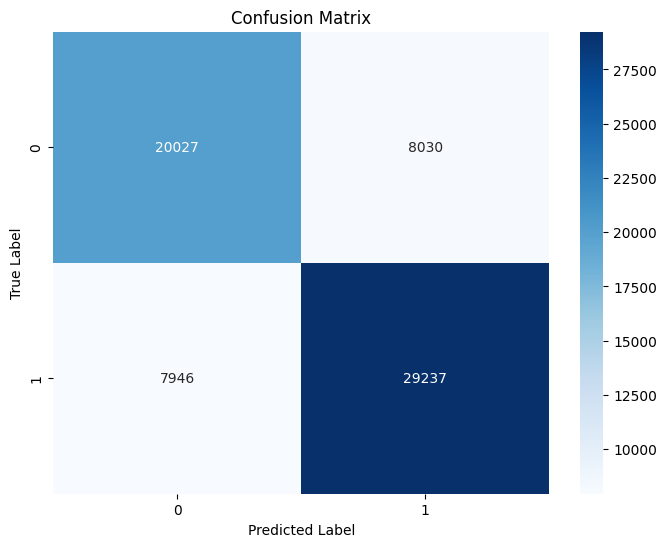

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Generate the confusion matrix
cm = confusion_matrix(actual_classes, predicted_classes)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()